In [8]:
!pip install -qq datasets
!pip install -qq openai

# Data Preparation

In [5]:
from datasets import load_dataset
import pandas as pd

# Load the AG News dataset from the Hugging Face 'datasets' library
dataset = load_dataset("ag_news")

# Preview the dataset structure
print(dataset)

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [6]:
ds = load_dataset("fka/awesome-chatgpt-prompts")# Map the prediction index to the class name (if you have a label map)
label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

In [4]:
import pandas as pd
# Preview the dataset structure
print(ds)

DatasetDict({
    train: Dataset({
        features: ['act', 'prompt'],
        num_rows: 153
    })
})


# Preparing to Connect to Cloud-based Language Model

In [9]:
# !!!! NOTE
#USE_GENERATED_DATA = False  # <-- use GPT 3.5
USE_GENERATED_DATA = True    # <-- use pre-generated texts from GPT 3.5

# Implementing the Prompt Constructor

In [10]:
# Function to add a prompt to the texts
def make_topic_cls_prompt(text):
    return f"Task : Topic Classification. Topic-class must be one of the (World, Sports, Business, Sci/Tech). The text is [{text}]. What is topic?"

In [11]:
def map_generated_to_topic(generated_text):
    generated_text = generated_text.lower()
    if "world" in generated_text:
        return "World"
    elif "sport" in generated_text:
        return "Sports"
    elif "business" in generated_text:
        return "Business"
    elif "sci" in generated_text:
        return "Sci/Tech"
    elif "technology" in generated_text:
        return "Sci/Tech"
    else:
        return "Unknown"

# Preparing the GPT 3.5 Language Model


Preparing the OpenAI Model

In [12]:
if USE_GENERATED_DATA == False:
  import os
  # Replace 'your_openai_api_key' with your actual OpenAI API key
  os.environ["OPENAI_API_KEY"] = ""  # <--- set your OPENAI API KEY
  # -----
  from openai import OpenAI
  client = OpenAI()
  import json
  def query_to_gpt(text):
      response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
          {"role": "user", "content": f"{text}"}
        ]
      )
      return response.choices[0].message. Content
  # ---
  sample_text = "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
  # Query GPT-3.5
  prompt = make_topic_cls_prompt(sample_text)
  generated_text = query_to_gpt(prompt)
  print("Generated text:", generated_text)
  # Prediction with generated text
  #    : Map the generated text to a topic
  predicted_topic = map_generated_to_topic(generated_text)
  print(f"Predicted Topic: {predicted_topic}")

# Performing Classification on Evaluation Data

In [13]:
import requests
from datasets import Dataset

if USE_GENERATED_DATA == True:
  print("[Download] dataset download")
  url = 'https://www.dropbox.com/scl/fi/n7wappv0dbh6jta6ghfon/subset_dataset.json?rlkey=0lcqfndfcndn6vfsudthbrmmm&st=nli9kv1s&dl=1'
  # Download the file content
  response = requests.get(url)
  response.raise_for_status()  # Ensure the request was successful
  dataset_json = response.json()  # Convert the response to JSON
  # Convert JSON data to DataFrame
  df = pd.DataFrame(dataset_json)
  # Convert DataFrame to Hugging Face dataset
  subset_test_dataset = Dataset.from_pandas(df)
  print("Dataset loaded and converted to Hugging Face dataset format.")
else:
  subset_test_dataset = dataset['test'].select( range(100) ) # sample 100
  subset_test_dataset = subset_test_dataset.add_column("generated_text", ['']*len(subset_test_dataset))

[Download] dataset download
Dataset loaded and converted to Hugging Face dataset format.


In [14]:
subset_test_dataset

Dataset({
    features: ['text', 'label', 'generated_text', '__index_level_0__'],
    num_rows: 100
})

In [15]:
subset_test_dataset['generated_text'][:5]

['Business',
 'The topic is Sci/Tech.',
 'The topic of the text is Sci/Tech.',
 'The topic of the text is Sci/Tech, as it discusses the use of a prediction unit to forecast wildfires.',
 'The topic of the text is "Sci/Tech" (Science/Technology) as it discusses Southern California\'s efforts to reduce air pollution from dairy cow manure.']

In [16]:
['Business',
 'The topic is Sci/Tech.',
 'The topic of the text is Sci/Tech.',
 'The topic of the text is Sci/Tech, as it discusses the use of a prediction unit to forecast wildfires.',
 'The topic of the text is "Sci/Tech" (Science/Technology) as it discusses Southern California\'s efforts to reduce air pollution from dairy cow manure.']

['Business',
 'The topic is Sci/Tech.',
 'The topic of the text is Sci/Tech.',
 'The topic of the text is Sci/Tech, as it discusses the use of a prediction unit to forecast wildfires.',
 'The topic of the text is "Sci/Tech" (Science/Technology) as it discusses Southern California\'s efforts to reduce air pollution from dairy cow manure.']

In [17]:
import pandas as pd
from tqdm import tqdm
data = {'text':[], 'pred_label':[], 'ref_label':[], 'llm_answer':[]}

for text, ref_label, _gen in tqdm(zip(subset_test_dataset['text'],
                                      subset_test_dataset['label'],
                                      subset_test_dataset['generated_text']
                                      )):
    prompt = make_topic_cls_prompt(text)
    generated_text = _gen if USE_GENERATED_DATA else query_to_gpt(prompt)
    predicted_label = map_generated_to_topic(generated_text)
    data['text'].append(text)
    data['pred_label'].append(predicted_label)
    data['ref_label'].append(label_map[ref_label])
    data['llm_answer'].append(generated_text)
result_df = pd.DataFrame(data)
result_df

100it [00:00, 71906.46it/s]


,text,pred_label,ref_label,llm_answer
0,Fears for T N pension after talks Unions repre...,Business,Business,Business
1,The Race is On: Second Private Team Sets Launc...,Sci/Tech,Sci/Tech,The topic is Sci/Tech.
2,Ky. Company Wins Grant to Study Peptides (AP) ...,Sci/Tech,Sci/Tech,The topic of the text is Sci/Tech.
3,Prediction Unit Helps Forecast Wildfires (AP) ...,Sci/Tech,Sci/Tech,"The topic of the text is Sci/Tech, as it discu..."
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,Sci/Tech,Sci/Tech,"The topic of the text is ""Sci/Tech"" (Science/T..."
...,...,...,...,...
95,Eriksson doesn #39;t feel any extra pressure f...,Sports,Sports,The topic of the text is Sports.
96,Injured Heskey to miss England friendly NEWCAS...,Sports,Sports,Sports
97,"Staples Profit Up, to Enter China Market NEW ...",Business,Business,Business
98,Delegation Is Delayed Before Reaching Najaf AG...,World,World,The topic is World.


In [18]:
set( result_df.pred_label.values )

{'Business', 'Sci/Tech', 'Sports', 'Unknown', 'World'}

In [20]:
# Filtering the DataFrame where pred_label is 'Unknown'
filtered_df = result_df[result_df.pred_label == 'Unknown']

# Extracting unique llm_answer values that are in the specified set
filtered_answers = filtered_df.llm_answer[filtered_df.llm_answer.isin({'Business', 'Sci/Tech', 'Sports', 'Unknown', 'World'})].unique()

# Displaying the unique values
print(filtered_answers)


[]


In [23]:
# Assign 'World' class to 'Unknown' classes
result_df.loc[result_df.pred_label == 'Unknown', 'pred_label'] = 'World'

In [24]:
# import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Assuming result_df is your DataFrame and it's already defined
# Calculate metrics
accuracy = accuracy_score(result_df['ref_label'], result_df['pred_label'])
precision, recall, f1, _ = precision_recall_fscore_support(result_df['ref_label'], result_df['pred_label'], average='weighted')
# Create a DataFrame to display metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'Value': [accuracy, precision, recall, f1]
})
metrics_df.T

,0,1,2,3
Metric,Accuracy,Precision,Recall,F1-score
Value,0.79,0.875013,0.79,0.802883


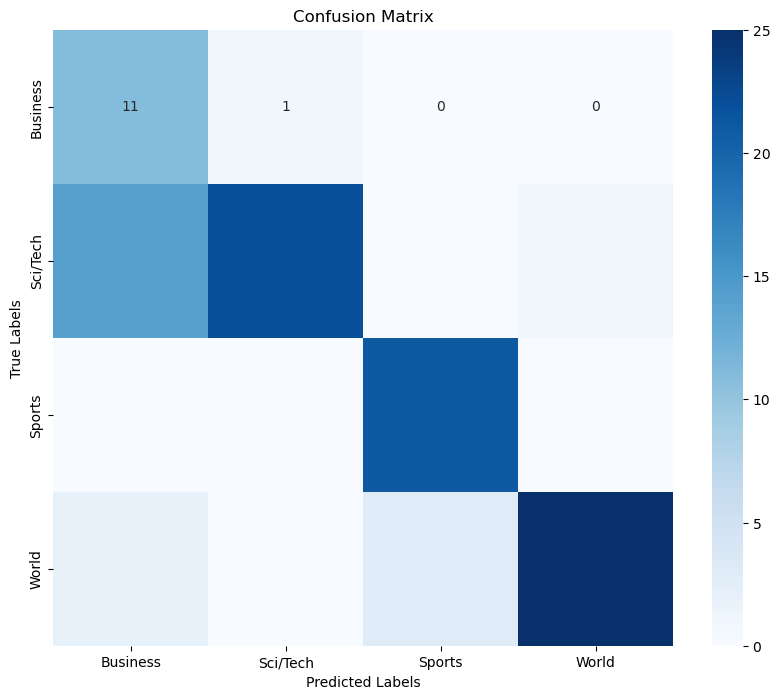

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(result_df['ref_label'], result_df['pred_label'])
# Get sorted unique labels
labels = sorted(result_df['ref_label'].unique())
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()